In [1]:
NOTE = 'Ridgeベクトルは除外しBatterIDでGroupKFold'
notebook_name = '081'
CV = 'GroupK-Fold(batterID)'
group_col = 'batterID'

In [2]:
import json
import os
import os.path
import pickle
import sys

import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
import seaborn as sns

SCRIPT_PATH = os.path.join('..', 'scripts')
if SCRIPT_PATH not in sys.path:
    sys.path.append(SCRIPT_PATH)
from features import CATEGORICAL_FEATURES, VECTOR_FEATURES

In [3]:
OUTPUT_DIR = os.path.basename(notebook_name)
SUB_FILENAME = notebook_name[:3] + '_submission.csv'
assert(SUB_FILENAME not in pd.read_csv('submissions.csv').filename.tolist())
print(SUB_FILENAME, OUTPUT_DIR)
if not os.path.isdir(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

SEED = 1

# class_weights for CatBoostClassifier, copied from 020
CLASS_WEIGHTS = {
        0: 0.33822833,
        1: 0.4574968, 
        2: 0.71590909,
        3: 1.00280899,
        4: 3.17333333,
        5: 11.45454545,
        6: 194.72727273,
        7: 17.85
    }

081_submission.csv 081


In [4]:
train = pd.read_csv(os.path.join('001_EDA', 'train_data_preprocessed.csv'))
test = pd.read_csv(os.path.join('001_EDA', 'test_data_preprocessed.csv'))

In [5]:
groups = train[group_col]

In [6]:
# Minimal features
minimal_features = [
    'inningNo',
    'totalPitchingCount',
    'B',
    'S',
    'O',
    'b1',
    'b2',
    'b3',
    'numRunners',
    'batterID',
    'pitcherID',
    'Match',
    'isBatterHandLeft',
    'isPitcherHandLeft',
    'isBatterPitcher',
    'isBottom',
    'batterTeam',
    'pitcherTeam',
]

# categorical_features = [f for f in minimal_features if f in CATEGORICAL_FEATURES]
# discrete_features = list(set(minimal_features) - set(categorical_features))
# print(categorical_features)
# print(discrete_features)

# Execute if categories should be one-hot style
## categorical features
for c in CATEGORICAL_FEATURES:
    assert(train[c].isin(test[c]).sum() == train.shape[0])
    assert(test[c].isin(train[c]).sum() == test.shape[0])
train = pd.get_dummies(train, columns=CATEGORICAL_FEATURES, drop_first=True)
test = pd.get_dummies(test, columns=CATEGORICAL_FEATURES, drop_first=True)
assert(set(train.columns.tolist()) - set(test.columns.tolist()) == {'y'})
assert(set(test.columns.tolist()) - set(train.columns.tolist()) == set())
categorical_features = []
for c in CATEGORICAL_FEATURES:
    categorical_features += [c_ for c_ in train.columns if c_.startswith(f'{c}_')]
## vector features
vector_features = VECTOR_FEATURES
## discrete features
discrete_features = [c for c in train.columns
                     if c not in ['y', 'id'] + vector_features + categorical_features]
## all features
features = categorical_features + discrete_features + vector_features

len(categorical_features), len(vector_features), len(discrete_features)

(1857, 384, 107)

In [7]:
categorical_features

['batterID_0',
 'batterID_2',
 'batterID_5',
 'batterID_9',
 'batterID_11',
 'batterID_12',
 'batterID_15',
 'batterID_18',
 'batterID_19',
 'batterID_21',
 'batterID_22',
 'batterID_26',
 'batterID_27',
 'batterID_28',
 'batterID_29',
 'batterID_31',
 'batterID_34',
 'batterID_36',
 'batterID_37',
 'batterID_39',
 'batterID_42',
 'batterID_45',
 'batterID_47',
 'batterID_50',
 'batterID_55',
 'batterID_56',
 'batterID_58',
 'batterID_60',
 'batterID_67',
 'batterID_70',
 'batterID_72',
 'batterID_73',
 'batterID_75',
 'batterID_80',
 'batterID_82',
 'batterID_84',
 'batterID_85',
 'batterID_87',
 'batterID_89',
 'batterID_91',
 'batterID_98',
 'batterID_102',
 'batterID_103',
 'batterID_105',
 'batterID_106',
 'batterID_111',
 'batterID_112',
 'batterID_114',
 'batterID_117',
 'batterID_118',
 'batterID_120',
 'batterID_121',
 'batterID_125',
 'batterID_127',
 'batterID_128',
 'batterID_130',
 'batterID_132',
 'batterID_134',
 'batterID_135',
 'batterID_137',
 'batterID_138',
 'batter

In [8]:
discrete_features

['totalPitchingCount',
 'B',
 'S',
 'O',
 'inningNo',
 'numRunners',
 'pitcherHoursElapsed',
 'pitcherNumGamesParticipated',
 'batterHoursElapsed',
 'batterNumGamesParticipated',
 'speedcount',
 'speedmean',
 'speedstd',
 'speedmin',
 'speed25%',
 'speed50%',
 'speed75%',
 'speedmax',
 'speedrange',
 'speedmeanDiff',
 'speedstdDiff',
 'speedminDiff',
 'speed25%Diff',
 'speed50%Diff',
 'speed75%Diff',
 'speedmaxDiff',
 'pitchTypeRatioカットファストボール',
 'pitchTypeRatioカーブ',
 'pitchTypeRatioシュート',
 'pitchTypeRatioシンカー',
 'pitchTypeRatioストレート',
 'pitchTypeRatioスライダー',
 'pitchTypeRatioチェンジアップ',
 'pitchTypeRatioフォーク',
 'battersFaced',
 'gameIDCount',
 'numInningsSum',
 'inningFromMin',
 'inningFromMean',
 'inningFromMedian',
 'inningFromMax',
 'inningFromStd',
 'inningToMin',
 'inningToMean',
 'inningToMedian',
 'inningToMax',
 'inningToStd',
 'pitcherNumStrikeOuts',
 'pitcherNumWalks',
 'hitsAllowed',
 'K/9',
 'BB/9',
 'K1p/BB1p',
 'whips',
 'pitchersFaced',
 'batterNumStrikeOuts',
 'batterNumWa

In [9]:
vector_features

['ballPositionLabel__no_data__',
 'ど真ん中',
 '内角中心',
 '内角低め',
 '内角高め',
 '外角中心',
 '外角低め',
 '外角高め',
 '真ん中低め',
 '真ん中高め',
 'ballPositionLabeld1',
 'ballPositionLabeld2',
 'ballPositionLabeld3',
 'ballPositionLabeld4',
 'ballPositionLabeld5',
 'ballPositionLabeld6',
 'ballPositionLabeld7',
 'ballPositionLabeld8',
 'ballPositionLabeld9',
 'ballPositionLabeld10',
 'ballPositionLabeld11',
 'ballPositionLabeld12',
 'ballPositionLabeld13',
 'ballPositionLabeld14',
 'ballPositionLabeld15',
 'ballPositionLabeld16',
 'ballPositionLabeld17',
 'ballPositionLabeld18',
 'ballPositionLabeld19',
 'ballPositionLabeld20',
 'ballPositionLabeld21',
 'ballPositionLabeld22',
 'ballPositionLabeld23',
 'ballPositionLabeld24',
 'ballPositionLabeld25',
 'ballPositionLabeld26',
 'ballPositionLabeld27',
 'ballPositionLabeld28',
 'ballPositionLabeld29',
 'ballPositionLabeld30',
 'ballPositionLabeld31',
 'ballPositionLabeld32',
 'ballPositionLabeld33',
 'ballPositionLabeld34',
 'ballPositionLabeld35',
 'ballPositionLabe

In [10]:
# features = [c for c in train.columns if c not in ('id', 'y')]
# assert(set(features) - set(test.columns.tolist()) == set())

In [11]:
# discrete_features = [f for f in features if f not in categorical_features]
# discrete_features

In [12]:
with open(os.path.join('001_EDA', f'group_kfold_{group_col}.json'), 'r') as f:
    fold = json.load(f)
fold

{'0': [313,
  229,
  140,
  340,
  118,
  335,
  321,
  151,
  624,
  183,
  239,
  111,
  184,
  295,
  60,
  82,
  127,
  132,
  572,
  303,
  182,
  311,
  276,
  72,
  55,
  185],
 '1': [349,
  91,
  496,
  443,
  121,
  5,
  105,
  73,
  391,
  535,
  149,
  12,
  412,
  0,
  196,
  509,
  193,
  114,
  582,
  574,
  58,
  2,
  462,
  224,
  26],
 '2': [22,
  556,
  47,
  444,
  9,
  646,
  523,
  449,
  601,
  217,
  201,
  374,
  84,
  402,
  557,
  381,
  261,
  330,
  150,
  135,
  492,
  70,
  628,
  203,
  498],
 '3': [644,
  220,
  148,
  253,
  168,
  27,
  271,
  392,
  192,
  39,
  368,
  485,
  87,
  145,
  619,
  333,
  264,
  36,
  480,
  355,
  98,
  432,
  34,
  164],
 '4': [328,
  636,
  85,
  269,
  362,
  18,
  112,
  555,
  661,
  138,
  475,
  21,
  654,
  500,
  80,
  565,
  510,
  416,
  37,
  153,
  559,
  479,
  293],
 '5': [620,
  446,
  417,
  226,
  263,
  171,
  427,
  199,
  642,
  15,
  488,
  130,
  540,
  418,
  45,
  458,
  67,
  191,
  537,
  301,

In [13]:
%%time
# splitter = StratifiedKFold(shuffle=True, random_state=SEED, n_splits=N)
cv_pred_dfs = []
pred_dfs = []
metrics = {'train': [], 'valid': []}
models = []
# for i, (train_idx, valid_idx) in enumerate(splitter.split(train, train.y)):
for str_i, ids in fold.items():
    i = int(str_i)
    mask = groups.isin(ids)  # training/validation = False/True
    train_idx, id_train, X_train, y_train, valid_idx, id_valid, X_valid, y_valid = (
        train[~mask].index,
        train[~mask].id,
        train[~mask][features],
        train[~mask].y,
        train[mask].index,
        train[mask].id,
        train[mask][features],
        train[mask].y,
    )
    # feature transformation
    ## categorical features
    X_train_categorical = X_train.copy()[categorical_features]
    X_valid_categorical = X_valid.copy()[categorical_features]
    X_test_categorical = test.copy()[categorical_features]
    ## descrete features
    discrete_transformer = Pipeline(
        steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]
    ).fit(X_train.copy()[discrete_features])
    X_train_discrete = pd.DataFrame(
        data=discrete_transformer.transform(X_train.copy()[discrete_features]),
        columns=discrete_features,
        index=train_idx
    )
    X_valid_discrete = pd.DataFrame(
        data=discrete_transformer.transform(X_valid.copy()[discrete_features]),
        columns=discrete_features,
        index=valid_idx
    )
    X_test_discrete = pd.DataFrame(
        data=discrete_transformer.transform(test.copy()[discrete_features]),
        columns=discrete_features,
        index=test.index
    )
    discrete_transformer.feature_names__ = discrete_features
    discrete_transformer.input_features__ = discrete_features
    with open(os.path.join(OUTPUT_DIR, f'discrete_transformer_fold{i + 1}.pickle'), 'wb') as f:
        pickle.dump(discrete_transformer, f)
        f.close()
    ## vector features
    """
    vector_transformer = Pipeline(
        steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler()),
            ('decomposer', PCA(n_components=0.8, whiten=True, random_state=SEED))
        ]
    ).fit(X_train.copy()[vector_features])
    columns = [f'pca{i + 1}' for i in range(vector_transformer[-1].n_components_)]
    X_train_vector = pd.DataFrame(
        data=vector_transformer.transform(X_train.copy()[vector_features]),
        columns=columns,
        index=train_idx
    )
    X_valid_vector = pd.DataFrame(
        data=vector_transformer.transform(X_valid.copy()[vector_features]),
        columns=columns,
        index=valid_idx
    )
    X_test_vector = pd.DataFrame(
        data=vector_transformer.transform(test.copy()[vector_features]),
        columns=columns,
        index=test.index
    )
    vector_transformer.feature_names__ = vector_features
    vector_transformer.input_features__ = vector_features
    with open(os.path.join(OUTPUT_DIR, f'vector_transformer_fold{i + 1}.pickle'), 'wb') as f:
        pickle.dump(vector_transformer, f)
        f.close()
    """
    ## merge
    X_train_transformed = pd.concat([X_train_categorical,
                                     X_train_discrete,
#                                      X_train_vector
                                    ],
                                    axis=1)
    X_train_transformed.to_pickle(
        os.path.join(OUTPUT_DIR, f'train_features_fold{i + 1}.zip'),
        protocol=-1
    )

    X_valid_transformed = pd.concat([X_valid_categorical,
                                     X_valid_discrete,
#                                      X_valid_vector
                                    ],
                                    axis=1)
    X_valid_transformed.to_pickle(
        os.path.join(OUTPUT_DIR, f'valid_features_fold{i + 1}.zip'),
        protocol=-1
    )
    X_test_transformed = pd.concat([X_test_categorical,
                                    X_test_discrete,
#                                     X_test_vector
                                   ],
                                   axis=1)
    X_test_transformed.to_pickle(
        os.path.join(OUTPUT_DIR, f'test_features_fold{i + 1}.zip'),
        protocol=-1
    )
#     class_weight = compute_class_weight('balanced',
#                                         classes=np.sort(train.y.unique()),
#                                         y=y_train.values)
#     class_weight = dict(
#         zip(
#             np.sort(train.y.unique()),
#             class_weight
#         )
#     )
#     sample_weight = y_train.map(class_weight)
#     assert(sample_weight.isnull().sum() == 0)
    sample_weight = None
    # classification    
    clf = RidgeClassifier(max_iter=10000, class_weight='balanced', random_state=SEED)
    clf.fit(X_train_transformed,
            y_train.values,
            sample_weight=sample_weight)
    clf.feature_names__ = X_train_transformed.columns.tolist()
    with open(os.path.join(OUTPUT_DIR, f'model_fold{i + 1}.pickle'), 'wb') as f:
        pickle.dump(clf, f)
        f.close()
    models.append(clf)
    # Evaluate (trian set)
    pred_train = clf.predict(X_train_transformed)
    
    if pred_train.ndim > 1:
        pred_train = np.squeeze(pred_train)
    pred_train_df = pd.DataFrame(
        {
            'id': id_train,
            'actual': y_train,
            'prediction': pred_train,
        }
    )
    pred_train_df['train'] = 0
    print('*' * 10 + f'Confusion matrix for train set (Fold {i + 1})' + '*' * 10)
    print(confusion_matrix(y_train, pred_train))
    print()
    metrics['train'].append(f1_score(y_train, pred_train, average='macro'))
    # Evaluate (valid set)
    pred_valid = clf.predict(X_valid_transformed)
    if pred_valid.ndim > 1:
        pred_valid = np.squeeze(pred_valid)
    pred_valid_df = pd.DataFrame(
        {
            'id': id_valid,
            'actual': y_valid,
            'prediction': pred_valid,
        }
    )
    pred_valid_df['train'] = 1
    print('*' * 10 + f'Confusion matrix for validation set (Fold {i + 1})' + '*' * 10)
    print(confusion_matrix(y_valid, pred_valid))
    print()
    metrics['valid'].append(f1_score(y_valid, pred_valid, average='macro'))
    # Save cv result
    cv_pred_df = pd.concat([pred_train_df, pred_valid_df], axis=0)
    cv_pred_df['fold'] = i + 1
    cv_pred_dfs.append(cv_pred_df)
    # Inference
    try:
        infer = clf.predict_proba(X_test_transformed)
    except AttributeError:
        infer = clf.decision_function(X_test_transformed)
    pred_df = pd.DataFrame(
        data=infer,
        columns=clf.classes_
    )
    pred_df['id'] = test.id.values
    pred_df['fold'] = i + 1
    pred_dfs.append(pred_df)


**********Confusion matrix for train set (Fold 1)**********
[[1362  765  610  726  902  637   74  521]
 [ 465 1349  443  473  574  410   49  383]
 [ 216  297  758  364  458  266   33  230]
 [ 138  139  193  833  278  152   26  136]
 [  18   15   20   12  431   39    3   38]
 [   0    0    0    0    0  157    2    6]
 [   0    0    0    0    0    0    9    0]
 [   0    0    0    0    0    0    0  107]]

**********Confusion matrix for validation set (Fold 1)**********
[[128  90  97  86 157  75  12  91]
 [ 64 118  69  45 124  61   5  50]
 [ 38  45  48  38 109  43   7  42]
 [ 16  30  35  48  57  30   4  21]
 [  7   6  18  17  24  13   2  12]
 [  1   3   3   5   3   3   3   1]
 [  0   0   0   0   1   1   0   0]
 [  2   1   0   1   8   0   0   1]]

**********Confusion matrix for train set (Fold 2)**********
[[1354  789  607  759  865  665  112  497]
 [ 487 1355  445  517  560  431   81  349]
 [ 221  308  784  387  431  274   51  210]
 [ 128  143  226  844  275  148   50  126]
 [  23   19   1

In [14]:
metrics = pd.DataFrame(metrics).describe()
metrics.to_csv(os.path.join(OUTPUT_DIR, 'metrics.csv'))
metrics

,train,valid
count,10.000000,10.000000
mean,0.265006,0.126460
std,0.001909,0.007596
min,0.262237,0.114772
25%,0.263749,0.119852
50%,0.264693,0.127196
75%,0.265870,0.132052
max,0.269020,0.137138


In [15]:
cv_results = pd.concat(cv_pred_dfs)
cv_results.to_csv(os.path.join(OUTPUT_DIR, 'cross_validation.csv'), index=False)
cv_results

,id,actual,prediction,train,fold
0,0,0,0,0,1
1,1,1,4,0,1
2,2,0,4,0,1
3,3,2,4,0,1
4,4,4,4,0,1
...,...,...,...,...,...
17078,1434,2,4,1,10
17079,1435,3,3,1,10
17133,9762,1,1,1,10
17134,9763,2,1,1,10


In [16]:
submission_ = pd.concat(pred_dfs)
submission_

,0,1,2,3,4,5,6,7,id,fold
0,-0.601770,-0.634008,-0.580603,-0.957612,-0.112189,-0.986955,-1.032112,-1.094751,27446,1
1,-0.657500,-0.802132,-0.508012,-0.641011,-0.420349,-0.840288,-0.875675,-1.255032,113,1
2,-0.470528,-0.564383,-0.573715,-0.772333,-0.588885,-0.916208,-0.880309,-1.233641,4479,1
3,-0.523861,-0.644740,-0.608973,-0.719504,-0.517016,-0.893836,-0.916595,-1.175475,29080,1
4,-0.358422,-0.828705,-0.735200,-0.785538,-1.170229,0.096447,-1.067638,-1.150716,19319,1
...,...,...,...,...,...,...,...,...,...,...
33803,-0.738190,-0.477060,-0.667590,-0.268916,-0.971413,-0.996561,-1.033156,-0.847114,24272,10
33804,-0.878333,-0.972901,-0.764293,-0.416448,-0.549752,-0.886470,-0.992789,-0.539015,29106,10
33805,-1.029786,-0.931596,-0.662776,-0.404086,-0.576751,-0.928671,-1.044822,-0.421511,20679,10
33806,-0.546078,-0.985947,-0.750595,-0.396284,-0.513830,-1.069571,-0.982374,-0.755322,25901,10


In [17]:
submission_ = submission_.groupby('id')[[0, 1, 2, 3, 4, 5, 6, 7]].sum().sort_index().reset_index()
submission_

,id,0,1,2,3,4,5,6,7
0,0,-5.507305,-3.575210,-5.853969,-2.794626,-8.367384,-10.553298,-11.199836,-12.148373
1,1,-5.354418,-3.496712,-6.707324,-5.136218,-12.612214,-6.131658,-9.758349,-10.803108
2,2,-11.640064,-7.972753,-5.449779,-3.975393,0.336295,-8.977366,-11.407408,-10.913532
3,3,-3.320659,-4.857950,-8.398053,-6.484986,-9.587483,-9.785443,-10.243922,-7.321504
4,4,-7.543600,-2.303248,-9.940010,-6.571582,-0.397763,-12.311627,-10.067543,-10.864626
...,...,...,...,...,...,...,...,...,...
33803,33803,-3.956403,-6.018823,-4.942090,-9.924374,-6.020388,-12.048832,-9.060824,-8.028267
33804,33804,-4.087858,-6.541214,-7.765230,-3.745120,-7.393345,-11.189037,-11.290357,-7.987840
33805,33805,-4.643958,-8.613467,-9.172377,-5.496564,-6.641049,-8.167986,-10.221863,-7.042735
33806,33806,-12.813513,-6.763019,-5.947433,-3.588970,-4.495454,-5.270252,-9.856624,-11.264736


In [18]:
submission = pd.DataFrame(
    {
        'id': submission_.id,
        'y' : np.argmax(submission_[[0, 1, 2, 3, 4, 5, 6, 7]].values, axis=1)
    }
)
submission

,id,y
0,0,3
1,1,1
2,2,4
3,3,0
4,4,4
...,...,...
33803,33803,0
33804,33804,3
33805,33805,0
33806,33806,3


0    0.369573
1    0.273226
2    0.174603
3    0.124650
4    0.039391
5    0.010913
6    0.000642
7    0.007003
Name: y, dtype: float64

0    0.178804
1    0.183389
2    0.069983
3    0.201284
4    0.127071
5    0.082318
6    0.018842
7    0.138310
Name: y, dtype: float64

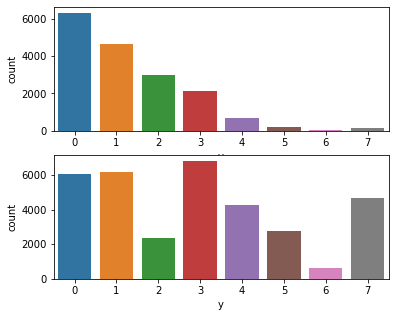

In [19]:
fig = plt.figure(figsize=(6., 5.))
fig.add_subplot(2, 1, 1)
sns.countplot(data=train, x='y')
fig.add_subplot(2, 1, 2)
sns.countplot(data=submission, x='y')
display(train.y.value_counts(normalize=True).sort_index())
display(submission.y.value_counts(normalize=True).sort_index())

In [20]:
submission.to_csv(os.path.join(OUTPUT_DIR, SUB_FILENAME), index=False)

In [21]:
metrics.loc['mean', 'train'], metrics.loc['mean', 'valid']

(0.26500621654206996, 0.12645974007904892)

In [22]:
print('"{}","{}","{:.6f}","{:.6f}","","{}"'.format(SUB_FILENAME, CV, metrics.loc['mean', 'train'], metrics.loc['mean', 'valid'], NOTE))

"081_submission.csv","GroupK-Fold(batterID)","0.265006","0.126460","","Ridgeベクトルは除外しBatterIDでGroupKFold"


In [23]:
%%time
imp_df = pd.DataFrame()
for i, final_estimator in enumerate(models):
    try:
        if hasattr(final_estimator, 'feature_importances_'):
            feature_importance = final_estimator.feature_importances_
        else:
            feature_importance = final_estimator.final_estimator.get_feature_importance()
            
        if hasattr(final_estimator, 'feature_name_'):
            feature_names = final_estimator.feature_name_
        elif hasattr(final_estimator, 'feature_names_'):
            feature_names = final_estimator.feature_names_
        else:
            feature_names = final_estimator.get_booster().feature_names
        imp_df_ = pd.DataFrame(
            {
                'feature': feature_names,
                'importance': feature_importance
            }
        )
        imp_df_['fold'] = i + 1
        imp_df = pd.concat([imp_df, imp_df_])
    except AttributeError:
        pass

if imp_df.shape[0] > 0:
    imp_df.to_csv(os.path.join(OUTPUT_DIR, 'feature_importances.csv'), index=False)

Wall time: 15.6 ms


In [24]:
imp_df

""


In [25]:
%%time
coef_df = pd.DataFrame()
for i, final_estimator in enumerate(models):
    try:
        if hasattr(final_estimator, 'coef_'):
            coefficient = final_estimator.coef_
            coef_df_ = pd.DataFrame(coefficient, columns=final_estimator.feature_names__)
            coef_df_['fold'] = i + 1
            coef_df_['y'] = final_estimator.classes_
            coef_df = pd.concat([coef_df, coef_df_])
    except AttributeError:
        pass

if coef_df.shape[0] > 0:
    coef_df.to_csv(os.path.join(OUTPUT_DIR, 'coefficients.csv'), index=False)

Wall time: 219 ms


In [26]:
coef_df

,batterID_0,batterID_2,batterID_5,batterID_9,batterID_11,batterID_12,batterID_15,batterID_18,batterID_19,batterID_21,...,distDirS,distDirT,distDirU,distDirV,distDirW,distDirX,distDirY,distDirZ,fold,y
0,0.093135,-0.069848,0.070234,-0.047561,0.087487,-0.113900,0.154598,-0.013774,-0.200635,0.242402,...,0.008813,0.021793,-0.010945,-0.023261,-0.027415,-0.032724,-0.002199,-0.007607,1,0
1,0.175875,0.354013,-0.270024,0.076083,-0.017084,-0.143391,-0.077730,-0.150615,-0.207639,-0.109916,...,0.007940,0.012798,0.018979,-0.017271,-0.006978,0.019890,0.011637,0.002083,1,1
2,0.248957,-0.043602,-0.099435,0.091611,-0.027541,0.096701,-0.128768,-0.000064,-0.128335,0.032491,...,-0.019392,-0.011126,0.014107,-0.012194,0.011195,0.026282,0.013145,0.034599,1,2
3,-0.039277,0.051994,-0.028252,-0.005359,-0.011466,-0.164963,0.117523,-0.114048,0.134693,-0.109253,...,0.029983,0.029521,-0.033581,0.005582,0.031752,-0.043997,0.033939,0.002074,1,3
4,0.116709,-0.462958,-0.016501,0.129934,0.076586,0.009290,0.017075,-0.054443,0.254229,-0.072574,...,0.001375,-0.014397,-0.036452,0.006804,-0.020283,-0.009475,-0.027237,-0.022585,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3,-0.069072,0.015586,-0.032937,0.036680,-0.124511,-0.138289,0.108173,-0.092727,0.055261,-0.124285,...,0.031014,0.017168,-0.035302,-0.003662,0.041130,-0.046278,0.034440,0.005637,10,3
4,0.074034,-0.338677,-0.079425,0.111234,0.037640,0.076155,0.005226,-0.083381,0.231778,-0.094612,...,-0.023456,-0.008603,-0.033684,0.008406,-0.001227,-0.009785,-0.023151,-0.045822,10,4
5,-0.350398,0.027746,-0.108084,-0.031564,-0.021009,0.115320,0.207243,-0.041982,-0.124797,0.212125,...,0.010825,0.010047,0.008394,0.015571,-0.040937,0.032696,-0.009888,0.033610,10,5
6,-0.060936,0.087986,-0.008575,-0.025560,-0.098079,0.038143,0.103755,0.096530,0.527009,0.097098,...,-0.005056,-0.032890,0.051951,-0.036329,-0.017870,0.014734,-0.013976,-0.025550,10,6
